<a href="https://colab.research.google.com/github/ykristing/ykristing.github.io/blob/main/socioeconomics_and_crime_MD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# To Do
- more regression probably
  - note: John said low accuracy scores are ok on piazza 
  - note: the variables don't really explain crime rates??? maybe try multiple regression but idk if that would even help
  - i think for now focus on doing more visualization and def have a lot of writing to do for the prose part of the proj
    - example of visualization would be draw regression line on plot - could draw multiple regression lines for each of the variables on one plot
- make into tutorial
- clean up stuff if it doesnt work - map stuff and poly reg

# Exploration of Crime and Socioeconomic Data
## Kristi Ng, Telon Yan

It is generally believed that socioeconomic factors have some correlation or relationship with crime<sup>[1]</sup>. Numerous studies have been done examining the intricacies of this relationship in what specific factors might affect crime, and if it is just a correlation or if there is some causality to it<sup>[2][3][4][5]</sup>. Studying this relationship may give us insights to make more informed and data-driven policy decisions, ideally to reduce crime, or at least to know where to expect crime to happen. 

We will examine Maryland specifically to see if generally accepted trends apply in our community. With this analysis, we hope to encourage the UMD community and Maryland community as a whole to advocate for better policies to reduce crime and improve quality of life for everyone. 

### The data science pipeline is composed of 5 main processes: 

####1.   Data Collection
####2.   Data Processing
####3.   Exploratory Analysis and Data Visualization
####4.   Analysis, Hypothesis Testing, and Machine Learning
####5.   Insight and Policy Decision

###This tutorial uses crime and socioeconomic data to demonstrate how each of these processes are used to find and utilize relationships (or a lack of a relationship). It is important to note that the pipeline is not a one-way track, steps can be revisited throughout the overall process of working with data.

In [ ]:
#!pip install geopandas==0.3.0
#!pip install pyshp==1.2.10
#!pip install shapely==1.6.3
#!pip install plotly-geo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
import statsmodels.api as sm
import decimal
import statsmodels.formula.api as smf
from sklearn.metrics import r2_score

#import geopandas
#import shapely
#import shapefile
#import plotly
#from plotly.figure_factory._county_choropleth import create_choropleth
#import xlrd
# Check your version
#print(plotly.__version__, geopandas.__version__,shapely.__version__,shapefile.__version__)

# Data Collection - Importing Data from GitHub
#### Socioeconomic characteristics and violent crime data for Maryland In this step of the pipeline, data is gathered in order to be analyzed. Many datasets can be found online for public use, for example, our datasets were found on opendata.maryland.gov. Data can also be collected using methods such as surveys or scraping websites for data. To get our datasets, we found two sets of data for Maryland jurisdictions (23 counties and Balitmore City) that we wanted to find a relationship between, uploaded them to Github, and then imported them to our code using GitHub. This step may be revisited if there is missing data, incorrect data, or new data needs to be obtained. 


Importing data

In [ ]:
# links to data sets
socio_url = 'https://raw.githubusercontent.com/ykristing/ykristing.github.io/main/Maryland_Counties_Socioeconomic_Characteristics.csv'
vc_url = 'https://raw.githubusercontent.com/ykristing/ykristing.github.io/main/Violent_Crime___Property_Crime_by_County__1975_to_Present.csv'
federal_url = 'https://raw.githubusercontent.com/plotly/datasets/master/minoritymajority.csv'

# reading data sets into dataframes
socio_df = pd.read_csv(socio_url)
vc_df = pd.read_csv(vc_url)
federal_df = pd.read_csv(federal_url)
display(socio_df.head())
display(vc_df.head())
display(federal_df.head())

,Jurisdictions,Total Households,Population 25 years and older,Less than 9th Grade,High School no Diploma,High School Diploma,Some College no degree,Associates degree,Bachelor's degree,Graduate or Professional,Employment Status of the Population 16 years and over,Civilian Labor Force (16 years & over),Employed,Unemployed,Unemployment Rate,Commute Workers 16 yrs and over,Percent Drove Alone,Percent Carpooled,Percent Public Transportation,Percent Walked,Percent Other,Percent Worked at Home,Median Household Income ($),Families,Percent Families in Poverty,Percent Civilian Population w/ Health Ins. Cov.,Total Housing Units,Percent Occupied,Percent Vacant,Total Population,Voting Age Population,Male,Female,White Alone,Black Alone,Asian Alone,American Indian/Alaska Native Alone,Native Hawaiian/Pacific Islander Alone,Some Other Race Alone,Two or More Races,Hispanic or Latino (of any race)
0,Allegany County,27759,50489,1307,4002,21070,10154,4758,4888,4310,61337,31591,28738,2853,9.0,28108,82.5,9.7,0.5,4.4,1.2,1.7,42771,17126,10.6,94.1,33211,84.0,16.0,72591,58846,37892,34699,64164,5899,594,120,24,210,1580,1257
1,Anne Arundel County,205395,387306,9133,21910,93676,77911,29279,90536,64861,451557,306519,290628,15891,5.2,296978,80.1,7.5,3.6,2.3,1.4,5.1,94502,142696,3.9,94.6,219319,93.1,6.9,564600,418118,279581,285019,417111,91567,20818,1025,408,13095,20576,41275
2,Baltimore County,312859,573263,18315,32698,152622,112480,40355,125363,91430,670033,445373,420974,24399,5.5,412831,79.2,8.7,4.8,1.8,1.5,4.0,71810,204288,6.0,93.3,337031,93.0,7.0,828637,607614,392930,435707,514340,231516,49045,2320,398,8728,22290,42438
3,Calvert County,31462,61269,1096,2716,18833,15552,4642,10564,7866,71843,49333,45756,3577,7.3,45262,81.7,8.4,3.0,0.7,0.9,5.3,100350,23759,3.3,94.7,34613,90.4,9.6,90824,68233,45184,45640,73885,10797,1504,150,34,541,3913,3276
4,Caroline County,11996,22216,1230,2470,9079,4072,1687,2182,1496,25875,16761,15674,1087,6.5,15387,83.7,8.6,0.9,2.4,1.7,2.6,52469,8670,12.1,91.7,13525,88.4,11.6,32785,24049,15971,16814,26338,4376,190,96,18,721,1046,2247


,JURISDICTION,YEAR,POPULATION,MURDER,RAPE,ROBBERY,AGG. ASSAULT,B & E,LARCENY THEFT,M/V THEFT,GRAND TOTAL,PERCENT CHANGE,VIOLENT CRIME TOTAL,VIOLENT CRIME PERCENT,VIOLENT CRIME PERCENT CHANGE,PROPERTY CRIME TOTALS,PROPERTY CRIME PERCENT,PROPERTY CRIME PERCENT CHANGE,"OVERALL CRIME RATE PER 100,000 PEOPLE","OVERALL PERCENT CHANGE PER 100,000 PEOPLE","VIOLENT CRIME RATE PER 100,000 PEOPLE","VIOLENT CRIME RATE PERCENT CHANGE PER 100,000 PEOPLE","PROPERTY CRIME RATE PER 100,000 PEOPLE","PROPERTY CRIME RATE PERCENT CHANGE PER 100,000 PEOPLE","MURDER PER 100,000 PEOPLE","RAPE PER 100,000 PEOPLE","ROBBERY PER 100,000 PEOPLE","AGG. ASSAULT PER 100,000 PEOPLE","B & E PER 100,000 PEOPLE","LARCENY THEFT PER 100,000 PEOPLE","M/V THEFT PER 100,000 PEOPLE","MURDER RATE PERCENT CHANGE PER 100,000 PEOPLE","RAPE RATE PERCENT CHANGE PER 100,000 PEOPLE","ROBBERY RATE PERCENT CHANGE PER 100,000 PEOPLE","AGG. ASSAULT RATE PERCENT CHANGE PER 100,000 PEOPLE","B & E RATE PERCENT CHANGE PER 100,000 PEOPLE","LARCENY THEFT RATE PERCENT CHANGE PER 100,000 PEOPLE","M/V THEFT RATE PERCENT CHANGE PER 100,000 PEOPLE"
0,Allegany County,1975,79655,3,5,20,114,669,1425,93,2329,NaN,142,6.1,NaN,2187,93.9,NaN,2923.9,NaN,178.3,NaN,2745.6,NaN,3.8,6.3,25.1,143.1,839.9,1789.0,116.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Allegany County,1976,83923,2,2,24,59,581,1384,73,2125,-8.8,87,4.1,-38.7,2038,95.9,-6.8,2532.1,-13.4,103.7,-41.8,2428.4,-11.6,2.4,2.4,28.6,70.3,692.3,1649.1,87.0,-36.7,-62.0,13.9,-50.9,-17.6,-7.8,-25.5
2,Allegany County,1977,82102,3,7,32,85,592,1390,102,2211,4.0,127,5.7,46.0,2084,94.3,2.3,2693.0,6.4,154.7,49.2,2538.3,4.5,3.7,8.5,39.0,103.5,721.1,1693.0,124.2,53.3,257.8,36.3,47.3,4.2,2.7,42.8
3,Allegany County,1978,79966,1,2,18,81,539,1390,100,2131,-3.6,102,4.8,-19.7,2029,95.2,-2.6,2664.9,-1.0,127.6,-17.5,2537.3,0.0,1.3,2.5,22.5,101.3,674.0,1738.2,125.1,-65.8,-70.7,-42.2,-2.2,-6.5,2.7,0.7
4,Allegany County,1979,79721,1,7,18,84,502,1611,99,2322,9.0,110,4.7,7.8,2212,95.3,9.0,2912.7,9.3,138.0,8.2,2774.7,9.4,1.3,8.8,22.6,105.4,629.7,2020.8,124.2,0.3,251.1,0.3,4.0,-6.6,16.3,-0.7


,FIPS,STNAME,CTYNAME,TOT_POP,TOT_MALE,TOT_FEMALE,WA_MALE,WA_FEMALE,NHWA_MALE,NHWA_FEMALE,NHWhite_Alone,Not_NHWhite_Alone,MinorityMinority,MinorityPCT,Black,BlackPCT,Hispanic,HispanicPCT
0,18049,Indiana,Fulton County,20737,10369,10368,9985,10020,9561,9627,19188,1549,No,7.47%,170,1%,965,4.65%
1,18051,Indiana,Gibson County,33458,16642,16816,15873,16117,15648,15955,31603,1855,No,5.54%,667,2%,476,1.42%
2,18053,Indiana,Grant County,69330,33282,36048,29587,32460,28353,31398,59751,9579,No,13.82%,4936,7%,2656,3.83%
3,18055,Indiana,Greene County,32940,16479,16461,16179,16167,16029,15999,32028,912,No,2.77%,82,0%,351,1.07%
4,18057,Indiana,Hamilton County,289495,141103,148392,125675,131785,120979,127105,248084,41411,No,14.30%,11332,4%,10548,3.64%


# Data Processing

#### The data processing step of the pipeline is where we tidy up our data. Tidying up data may include standardizing values, deleting certain values, and anything else to make sure the data fits your needs. Since we were able to access public datasets, our data was relatively nice and didn’t need much work. We changed the jurisdiction column of the socioeconomic characteristic dataframe so that we could easily combine the two dataframes. There were an excess of columns in the socioeconomic characteristic dataframe, so we kept the columns of variables we wanted to look at. We also decided that we only wanted to look at overall crime rates and violent crime rates, so we combined those columns from the violent crime dataframe with the socioeconomic dataframe in order to keep all of our data in one dataframe. The violent crime dataset included years from 1975 to Present, but since the socioeconomic characteristic dataset only contains data for 2019, we filtered for the 2019 data. At this point our initial data processing was finished. However, later on we decided that we wanted to analyze additional variables as well as a variable that wasn’t in the table, so we included more existing columns from the socioeconomic dataframe and created another column for ‘College Degree or Higher Percentage’ by doing computations using other data columns in the table.    

In [ ]:
#clean up vc_df - only keep rows for year 2019
vc_df = vc_df.loc[vc_df['YEAR'] == 2019]
vc_df = vc_df.reset_index(drop=True)

#clean up federal_df - only keep rows for maryland counties
# https://raw.githubusercontent.com/plotly/datasets/master/minoritymajority.csv
federal_df = federal_df.loc[federal_df['STNAME']=='Maryland']
federal_df = federal_df.reset_index(drop=True)
federal_df['CTYNAME'] = federal_df['CTYNAME'].replace('Baltimore city','Baltimore City')

#clean up socio_df - drop most columns, change Baltimore city to Baltimore City (consistent w/ vc_df), reset index
socio_df['Jurisdictions'] = socio_df['Jurisdictions'].replace(['Baltimore city'], 'Baltimore City')
socio_df = socio_df.sort_values(by=['Jurisdictions'])
socio_df = socio_df.reset_index(drop=True)

# add new column to socio_df then drop extraneous columns
socio_df['College Degree or Higher Percentage'] = round(socio_df['Bachelor\'s degree']/vc_df['POPULATION']*100, 2)
socio_df = socio_df[['Jurisdictions', 'Population 25 years and older', 'Unemployment Rate', 'Median Household Income ($)', 'Percent Families in Poverty', 'College Degree or Higher Percentage']]

# combine wanted columns from vc_df with socio_df
overall_crime_col = vc_df['OVERALL CRIME RATE PER 100,000 PEOPLE']
socio_df = socio_df.join(overall_crime_col)
violent_crime_col = vc_df['VIOLENT CRIME RATE PER 100,000 PEOPLE']
socio_df = socio_df.join(violent_crime_col)
socio_df = socio_df.join(federal_df['FIPS'])
socio_df.head()

display(socio_df.head())

,Jurisdictions,Population 25 years and older,Unemployment Rate,Median Household Income ($),Percent Families in Poverty,College Degree or Higher Percentage,"OVERALL CRIME RATE PER 100,000 PEOPLE","VIOLENT CRIME RATE PER 100,000 PEOPLE",FIPS
0,Allegany County,50489,9.0,42771,10.6,6.97,2493.6,325.1,24001
1,Anne Arundel County,387306,5.2,94502,3.9,15.67,2142.4,317.9,24003
2,Baltimore City,425235,10.0,46641,17.2,11.35,6231.8,1873.0,24005
3,Baltimore County,573263,5.5,71810,6.0,15.16,3043.5,572.7,24009
4,Calvert County,61269,7.3,100350,3.3,11.49,1058.4,144.7,24011


# Data Exploration & Visualization
#### Exploratory analysis and visualization allows us to take a look at our data and make initial impressions based on said data. This step usually consists of creating visual plots in order to look at how our data is distributed or if there seems to be a trend. To start with, we looked at bar graphs of unemployment and overall crime because we wanted to look at the relationship between these variables.  

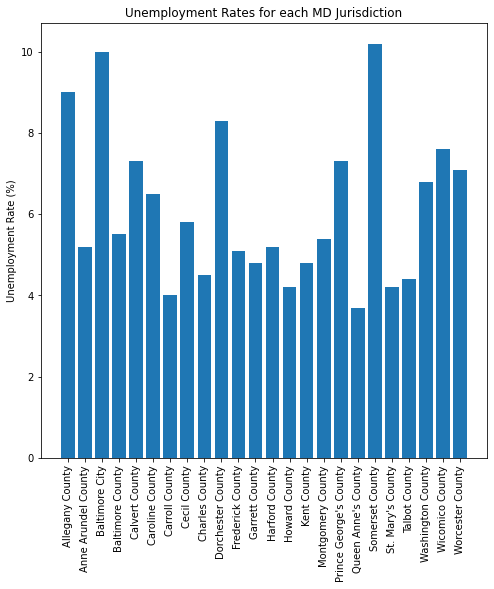

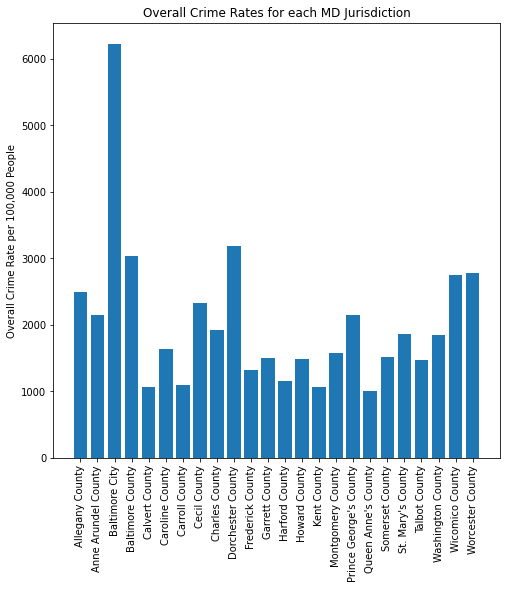

In [ ]:
# bar graph for Unemployment Rates for each MD Jurisdiction
plt.figure(figsize=(8,8))
plt.bar(socio_df['Jurisdictions'], socio_df['Unemployment Rate'])
plt.xticks(rotation=90)
plt.title("Unemployment Rates for each MD Jurisdiction")
plt.ylabel('Unemployment Rate (%)')
plt.show()

# bar graph for Overall Crime Rates for each MD Jurisdiction
plt.figure(figsize=(8,8))
plt.bar(socio_df['Jurisdictions'], socio_df['OVERALL CRIME RATE PER 100,000 PEOPLE'])
plt.xticks(rotation=90)
plt.title("Overall Crime Rates for each MD Jurisdiction")
plt.ylabel('Overall Crime Rate per 100,000 People')
plt.show()

#### Just by looking at the bar charts, we can see that Baltimore City sticks out as an outlier in terms of crime rate per 100,000 people. We will explore this more by looking at a scatterplot of unemployment rate vs overall crime rate. 

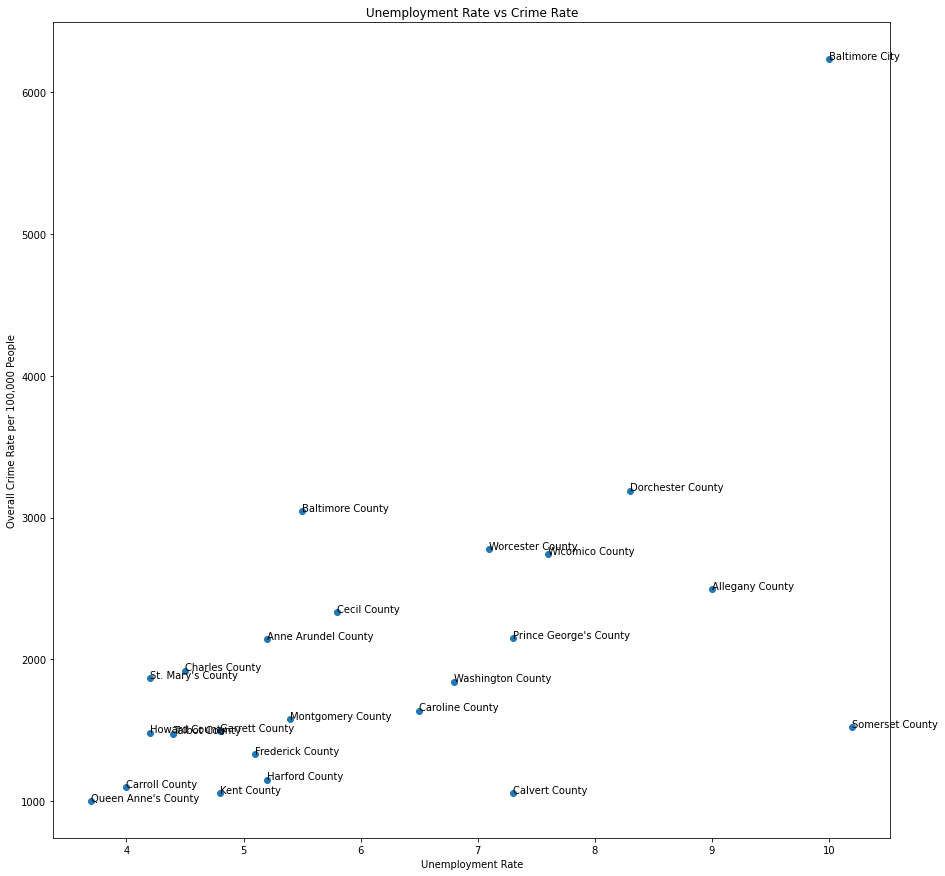

In [ ]:
# scatter plot for unemployment rate vs crime rate
plt.figure(figsize=(15, 15))
x=socio_df['Unemployment Rate']
y=socio_df['OVERALL CRIME RATE PER 100,000 PEOPLE']
plt.scatter(x, y)
plt.title ('Unemployment Rate vs Crime Rate')
plt.xlabel('Unemployment Rate')
plt.ylabel('Overall Crime Rate per 100,000 People')
# label points on plot w/ jurisdiction names
for i, label in enumerate(socio_df['Jurisdictions']):
  plt.annotate(label, (x[i], y[i]))
plt.show()

####The scatter plot also shows Baltimore to be an outlier in terms of overall crime rate, but not unemployment rate. Because of this, we’ll do some analysis of the relationship of the data with Baltimore in the dataset, but we will end up omitting this data point from the rest of our analysis because it may cause us to find a relationship that is not accurate for the whole dataset.  

In [ ]:
# find linear regression model for unemployment rate and overall crime rate w/ Baltimore
X = socio_df['Unemployment Rate'].values.reshape(-1, 1)
y = socio_df['OVERALL CRIME RATE PER 100,000 PEOPLE']
reg = LinearRegression().fit(X, y)
r_sq = reg.score(X,y)
slope =  reg.coef_[0]
intercept = reg.intercept_
print('Linear Regression Model:  Overall Crime Rate per 100,000 People = ', '{:.3f}'.format(slope),'*Unemployment Rate - ','{:.3f}'.format(abs(intercept)), sep='')
print('R Squared:  ', r_sq, sep='')

# get summary of regression results (find p-value for coeff)
X = sm.add_constant(X)
lr = sm.OLS(y, X).fit()
print(lr.summary())

Linear Regression Model:  Overall Crime Rate per 100,000 People = 349.041*Unemployment Rate - 110.699
R Squared:  0.35490888647383956
                                      OLS Regression Results                                     
Dep. Variable:     OVERALL CRIME RATE PER 100,000 PEOPLE   R-squared:                       0.355
Model:                                               OLS   Adj. R-squared:                  0.326
Method:                                    Least Squares   F-statistic:                     12.10
Date:                                   Mon, 20 Dec 2021   Prob (F-statistic):            0.00213
Time:                                           20:11:39   Log-Likelihood:                -196.47
No. Observations:                                     24   AIC:                             396.9
Df Residuals:                                         22   BIC:                             399.3
Df Model:                                              1                          

Using the standard significance level of 0.05, the p-value of 0.00213 < 0.05, meaning that we reject the null hypothesis; there is a 0.213% likelihood that the variance in crime rate with respect to unemployment rate would happen by random chance, so we have evidence that there is a relationship between Unemployment Rate and Overall Crime Rates by county. However, the R^2 Value is relatively low at 0.355. This means that only 35.5% of the variance in the data is explained by our linear model, so our model is not a very good predictor of crime rates. Since Baltimore City seems to be an outlier in the data, let's try running a regression on the data without Baltimore City.

Before, running a regression, we'll revisualize the data without Baltimore City to see if there is a clear relationship between unemployment rate and overall crime rate. 

,Jurisdictions,Population 25 years and older,Unemployment Rate,Median Household Income ($),Percent Families in Poverty,College Degree or Higher Percentage,"OVERALL CRIME RATE PER 100,000 PEOPLE","VIOLENT CRIME RATE PER 100,000 PEOPLE",FIPS
0,Allegany County,50489,9.0,42771,10.6,6.97,2493.6,325.1,24001
1,Anne Arundel County,387306,5.2,94502,3.9,15.67,2142.4,317.9,24003
2,Baltimore County,573263,5.5,71810,6.0,15.16,3043.5,572.7,24009
3,Calvert County,61269,7.3,100350,3.3,11.49,1058.4,144.7,24011
4,Caroline County,22216,6.5,52469,12.1,6.58,1637.0,135.7,24013


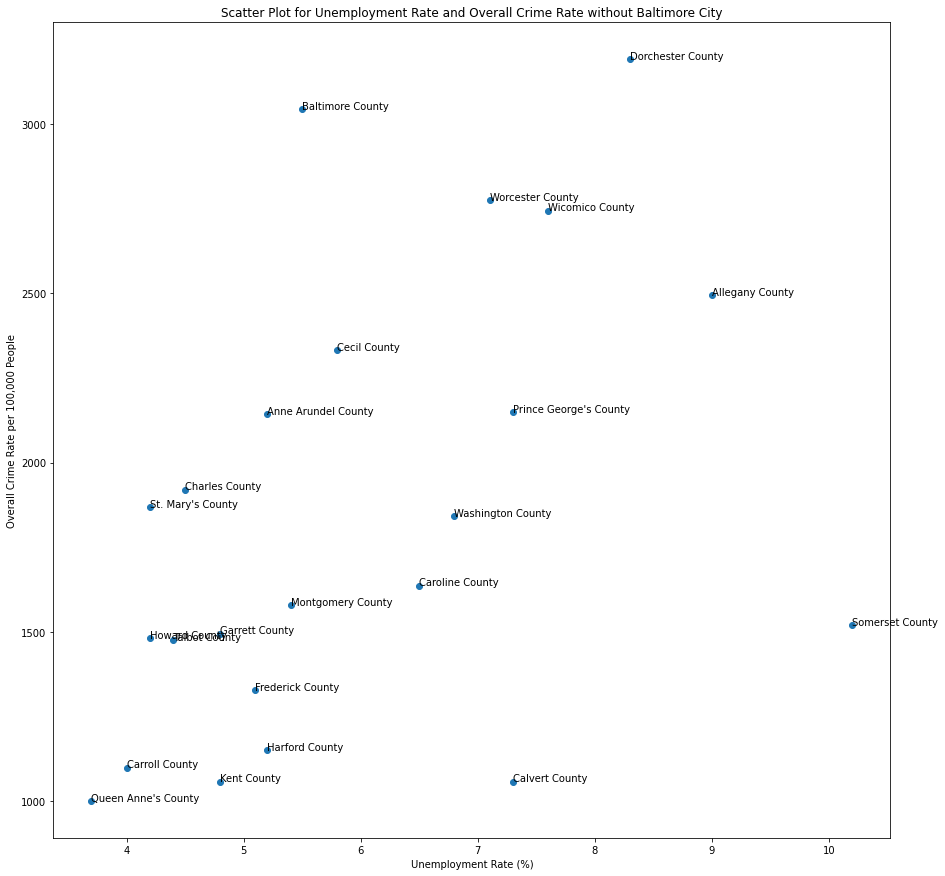

In [ ]:
# drop Baltimore City data from socio_df 
socio_df.drop(socio_df.index[(socio_df["Jurisdictions"] == "Baltimore City")], axis=0, inplace=True)
socio_df = socio_df.reset_index(drop=True)
display(socio_df.head())

# regression for unemployment rates and overall crime rates w/o Baltimore
plt.figure(figsize=(15, 15))
x=socio_df['Unemployment Rate']
y=socio_df['OVERALL CRIME RATE PER 100,000 PEOPLE']
plt.title('Scatter Plot for Unemployment Rate and Overall Crime Rate without Baltimore City')
plt.ylabel('Overall Crime Rate per 100,000 People')
plt.xlabel('Unemployment Rate (%)')
plt.scatter(x, y)
# label points on plot
for i, label in enumerate(socio_df['Jurisdictions']):
  plt.annotate(label, (x[i], y[i]))

There seems to be a positive relationship be

In [ ]:
#find linear regression model w/ unemployment rates w/o Baltimore
X = socio_df['Unemployment Rate'].values.reshape(-1, 1)
y = socio_df['OVERALL CRIME RATE PER 100,000 PEOPLE']
reg = LinearRegression().fit(X, y)
r_sq = reg.score(X,y)
slope_unemployment =  reg.coef_[0]
intercept_unemployment = reg.intercept_
print('Linear Regression Model:  Overall Crime Rate per 100,000 People = ', '{:.3f}'.format(slope_unemployment),'*Unemployment Rate - ','{:.3f}'.format(abs(intercept_unemployment)), sep='')
print('R Squared:  ', r_sq, sep='')

# get summary of regression results (find p-value)
X = sm.add_constant(X)
lr = sm.OLS(y, X).fit()
print(lr.summary())

Linear Regression Model:  Overall Crime Rate per 100,000 People = 174.430*Unemployment Rate - 804.608
R Squared:  0.20898714218965608
                                      OLS Regression Results                                     
Dep. Variable:     OVERALL CRIME RATE PER 100,000 PEOPLE   R-squared:                       0.209
Model:                                               OLS   Adj. R-squared:                  0.171
Method:                                    Least Squares   F-statistic:                     5.548
Date:                                   Mon, 20 Dec 2021   Prob (F-statistic):             0.0283
Time:                                           20:11:40   Log-Likelihood:                -178.80
No. Observations:                                     23   AIC:                             361.6
Df Residuals:                                         21   BIC:                             363.9
Df Model:                                              1                          

Excluding Baltimore City and using the same standard significance level of 0.05, the p-value for the coefficient x1, unemployment rate, is 0.028, meaning that there is a 2.8% likelihood that the variance in crime rate with respect to unemployment rate would happen by random chance. This shows that there is still a relationship between unemployment rate and overall crime rates by county. 

The R^2 value has decreased significantly however to 0.209, meaning that now, only 20.9% of the variance in the data is explained by unemployment rate. Since this is somewhat low, we will look at the other socioeconomic characteristics to see if they have a stronger relationship with crime, or if the combination of unemployment rate and other variables can be a better predictor via multiple linear regression. 

First we'll visualize the linear regression model using a scatter plot. 

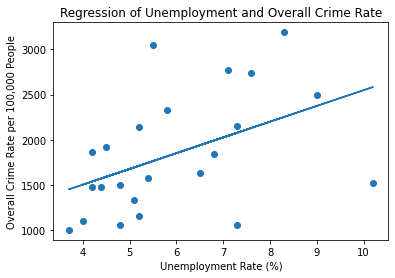

In [ ]:
# plot of linear regression model for unemployment and overall crime rate
x = socio_df['Unemployment Rate']
plt.scatter(x, y)
plt.plot(x, slope_unemployment*x + intercept_unemployment)
plt.title('Regression of Unemployment and Overall Crime Rate')
plt.xlabel('Unemployment Rate (%)')
plt.ylabel('Overall Crime Rate per 100,000 People')
plt.show()

The scatter plot shows us that the data points aren't really clustered near the regression line, especially for large values of unemployment rate. Since the p-value of linear regression tells us that there is certainly a relationship between the two variables, let's try finding a polynomial regression model that better fits the data.

(array([  -70.27086305,  1104.85072332, -2041.82790442]), array([6504838.32977926]), 3, array([1.69104849, 0.37339899, 0.03046623]), 5.10702591327572e-15)
[ 9.   5.2  5.5  7.3  6.5  4.   5.8  4.5  8.3  5.1  4.8  5.2  4.2  4.8
  5.4  7.3  3.7 10.2  4.2  4.4  6.8  7.6  7.1]


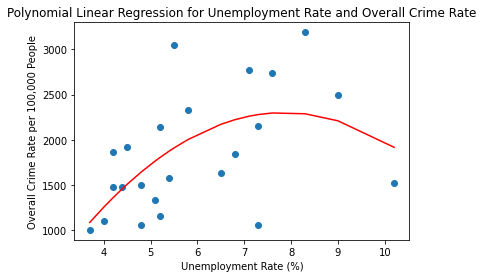

In [ ]:
# polynomial regression of degree 2
x = np.array(socio_df['Unemployment Rate'])
y = np.array(socio_df['OVERALL CRIME RATE PER 100,000 PEOPLE'])
# polyfit gives tuple of coefficients, residuals, rank, singular values, and rcond
coeffs = np.polyfit(x, y, deg=2, full=True)
#print(coeffs)
#print(x)

# plot regression line on scatter plot
plt.scatter(x, y)
x.sort()
line_x = np.linspace(1, 11)
y_reg = coeffs[0][0]*x*x + coeffs[0][1]*x + coeffs[0][2]
plt.plot(x, y_reg, color='r')
plt.title('Polynomial Linear Regression for Unemployment Rate and Overall Crime Rate')
plt.ylabel('Overall Crime Rate per 100,000 People')
plt.xlabel('Unemployment Rate (%)')
plt.show()

Even if this fits the data better, a quadratic fit of crime rate vs unemployment rate doesn’t really make much real-world sense, since it would imply that low and high unemployment both result in low crime, while crime rates are highest at some medium unemployment rate. Looking at the individual data points, one can also see that the far right point, Somerset County, is contributing the most to the quadratic shape, while excluding Somerset County visually makes the linear relationship appear more accurate. 

### Other Variables 

Since we previously saw that the R^2 value for the linear regression model for unemployment rate and crime rate is low, now we will look at the relationship between crime rate and other variables.


Linear Regression Model for Family Poverty Rate and Overall Crime Rate without Baltimore City

In [ ]:
#find linear regression model w/ familys in poverty w/o Baltimore
X = socio_df['Percent Families in Poverty'].values.reshape(-1, 1)
y = socio_df['OVERALL CRIME RATE PER 100,000 PEOPLE']
reg = LinearRegression().fit(X, y)
r_sq = reg.score(X,y)
slope_poverty =  reg.coef_[0]
intercept_poverty = reg.intercept_
print('Linear Regression Model:  Overall Crime Rate per 100,000 People = ', '{:.3f}'.format(slope_poverty),'*Percent Families in Poverty - ','{:.3f}'.format(abs(intercept_poverty)), sep='')
print('R Squared:  ', r_sq, sep='')

# get summary of regression results (find p-value)
X = sm.add_constant(X)
lr = sm.OLS(y, X).fit()
print(lr.summary())

Linear Regression Model:  Overall Crime Rate per 100,000 People = 60.720*Percent Families in Poverty - 1406.986
R Squared:  0.10739772094260747
                                      OLS Regression Results                                     
Dep. Variable:     OVERALL CRIME RATE PER 100,000 PEOPLE   R-squared:                       0.107
Model:                                               OLS   Adj. R-squared:                  0.065
Method:                                    Least Squares   F-statistic:                     2.527
Date:                                   Mon, 20 Dec 2021   Prob (F-statistic):              0.127
Time:                                           20:11:41   Log-Likelihood:                -180.19
No. Observations:                                     23   AIC:                             364.4
Df Residuals:                                         21   BIC:                             366.7
Df Model:                                              1                

Linear Regression Model for Higher Education Rate and Overall Crime Rate without Baltimore City

In [ ]:
#find linear regression model w/ population percentage with a college degree or higher w/o Baltimore
X = socio_df['College Degree or Higher Percentage'].values.reshape(-1, 1)
y = socio_df['OVERALL CRIME RATE PER 100,000 PEOPLE']
reg = LinearRegression().fit(X, y)
r_sq = reg.score(X,y)
slope_education =  reg.coef_[0]
intercept_education = reg.intercept_
print('Linear Regression Model:  Overall Crime Rate per 100,000 People = ', '{:.3f}'.format(slope_education),'*College Degree or Higher Percentage - ','{:.3f}'.format(abs(intercept_education)), sep='')
print('R Squared:  ', r_sq, sep='')

# get summary of regression results (find p-value)
X = sm.add_constant(X)
lr = sm.OLS(y, X).fit()
print(lr.summary())

Linear Regression Model:  Overall Crime Rate per 100,000 People = -42.219*College Degree or Higher Percentage - 2359.751
R Squared:  0.05478878598004633
                                      OLS Regression Results                                     
Dep. Variable:     OVERALL CRIME RATE PER 100,000 PEOPLE   R-squared:                       0.055
Model:                                               OLS   Adj. R-squared:                  0.010
Method:                                    Least Squares   F-statistic:                     1.217
Date:                                   Mon, 20 Dec 2021   Prob (F-statistic):              0.282
Time:                                           20:11:41   Log-Likelihood:                -180.85
No. Observations:                                     23   AIC:                             365.7
Df Residuals:                                         21   BIC:                             368.0
Df Model:                                              1       

Linear Regression Model for Median Income and Overall Crime Rate without Baltimore City

In [ ]:
#find linear regression model w/ median household income w/o Baltimore
X = socio_df['Median Household Income ($)'].values.reshape(-1, 1)
y = socio_df['OVERALL CRIME RATE PER 100,000 PEOPLE']
reg = LinearRegression().fit(X, y)
r_sq = reg.score(X,y)
slope_income =  reg.coef_[0]
intercept_income = reg.intercept_
print('Linear Regression Model:  Overall Crime Rate per 100,000 People = ', '{:.3f}'.format(slope_income),'*Median Household Income ($) - ','{:.3f}'.format(abs(intercept_income)), sep='')
print('R Squared:  ', r_sq, sep='')

# get summary of regression results (find p-value)
X = sm.add_constant(X)
lr = sm.OLS(y, X).fit()
print(lr.summary())

Linear Regression Model:  Overall Crime Rate per 100,000 People = -0.012*Median Household Income ($) - 2705.891
R Squared:  0.14496167264787552
                                      OLS Regression Results                                     
Dep. Variable:     OVERALL CRIME RATE PER 100,000 PEOPLE   R-squared:                       0.145
Model:                                               OLS   Adj. R-squared:                  0.104
Method:                                    Least Squares   F-statistic:                     3.560
Date:                                   Mon, 20 Dec 2021   Prob (F-statistic):             0.0731
Time:                                           20:11:41   Log-Likelihood:                -179.70
No. Observations:                                     23   AIC:                             363.4
Df Residuals:                                         21   BIC:                             365.7
Df Model:                                              1                

Visualizing the linear regression relationships using scatter plots 

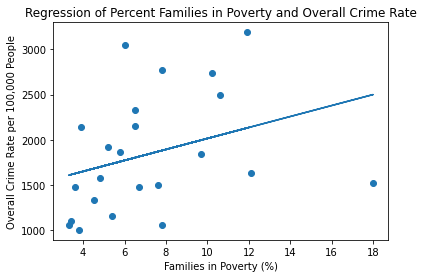

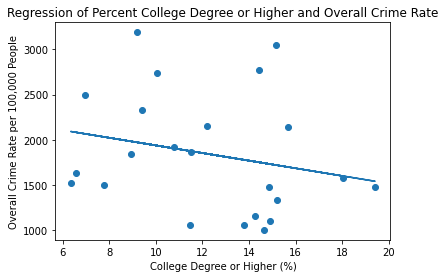

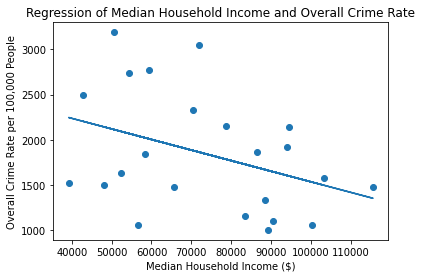

In [ ]:
# Linear Regression of Percent Families in Poverty and Overall Crime Rate
x = socio_df['Percent Families in Poverty']
plt.scatter(x, y)
plt.plot(x, slope_poverty*x + intercept_poverty)
plt.title('Regression of Percent Families in Poverty and Overall Crime Rate')
plt.xlabel('Families in Poverty (%)')
plt.ylabel('Overall Crime Rate per 100,000 People')
plt.show()

# Linear Regression of Higher Education Rate and Overall Crime Rate
x = socio_df['College Degree or Higher Percentage']
plt.scatter(x, y)
plt.plot(x, slope_education*x + intercept_education)
plt.title('Regression of Percent College Degree or Higher and Overall Crime Rate')
plt.xlabel('College Degree or Higher (%)')
plt.ylabel('Overall Crime Rate per 100,000 People')
plt.show()

# Linear Regression of Median Household Income and Overall Crime Rate
x = socio_df['Median Household Income ($)']
plt.scatter(x, y)
plt.plot(x, slope_income*x + intercept_income)
plt.title('Regression of Median Household Income and Overall Crime Rate')
plt.xlabel('Median Household Income ($)')
plt.ylabel('Overall Crime Rate per 100,000 People')
plt.show()

Looking at these variables and plots, none of them had a p value < 0.05 against overall crime rate, so we cannot claim that there is a statistically sigificant relationship between any of them and violent crime. Nonetheless, median household income seems to be the next strongest predictor. We therefore tried a multiple linear regression with unemployment rate and median household income.

In [ ]:
# multiple regression with unemployment rate, median household income, and overall crime rate
X = socio_df[['Unemployment Rate','Median Household Income ($)']]
y = socio_df['OVERALL CRIME RATE PER 100,000 PEOPLE']
reg = LinearRegression().fit(X, y)
r_sq = reg.score(X,y)
slope_unemployment =  reg.coef_[0]
slope_income =  reg.coef_[1]
intercept = reg.intercept_
print('Linear Regression Model: Overall Crime Rate per 100,000 People = ', '{:.3f}'.format(slope_unemployment),'*Unemployment Rate + ', '{:.3f}'.format(slope_income),'*Median Household Income($) - ','{:.3f}'.format(abs(intercept)), sep='')
print('R Squared:  ', r_sq, sep='')

# get summary of regression results (find p-value)
X = sm.add_constant(X)
lr = sm.OLS(y, X).fit()
print(lr.summary())

Linear Regression Model: Overall Crime Rate per 100,000 People = 136.982*Unemployment Rate + -0.005*Median Household Income($) - 1387.133
R Squared:  0.22452562390321573
                                      OLS Regression Results                                     
Dep. Variable:     OVERALL CRIME RATE PER 100,000 PEOPLE   R-squared:                       0.225
Model:                                               OLS   Adj. R-squared:                  0.147
Method:                                    Least Squares   F-statistic:                     2.895
Date:                                   Mon, 20 Dec 2021   Prob (F-statistic):             0.0786
Time:                                           20:11:42   Log-Likelihood:                -178.57
No. Observations:                                     23   AIC:                             363.1
Df Residuals:                                         20   BIC:                             366.6
Df Model:                                     

This did not seem to create a strong relationship. The p-values for both variables shot up significantly, and the adjusted R^2 for this multiple regression is 0.147, lower than the adjusted R^2 for the single regression with unemployment rate of 0.171. We therefore discarded this regression and went back to the regression with just unemployment rate.

# Side explorations
We wanted to see if these factors had a better correlation against violent crime rate instead of overall crime rate, but the relationships seemed weaker, so we did not continue pursuing this.

In [ ]:
#socio_df =socio_df.join(vc_df['VIOLENT CRIME RATE PER 100,000 PEOPLE'])

#find linear regression model w/ median household income w/o Baltimore for violent crime
X = socio_df['Median Household Income ($)'].values.reshape(-1, 1)
y = socio_df['VIOLENT CRIME RATE PER 100,000 PEOPLE']
reg = LinearRegression().fit(X, y)
r_sq = reg.score(X,y)
slope =  reg.coef_[0]
intercept = reg.intercept_
print('Linear Regression Model:  Violent Crime Rate per 100,000 People = ', '{:.3f}'.format(slope),'*Median Household Income ($) - ','{:.3f}'.format(abs(intercept)), sep='')
print('R Squared:  ', r_sq, sep='')

# get summary of regression results (find p-value)
X = sm.add_constant(X)
lr = sm.OLS(y, X).fit()
print(lr.summary())

Linear Regression Model:  Violent Crime Rate per 100,000 People = -0.002*Median Household Income ($) - 387.413
R Squared:  0.10641305638825704
                                      OLS Regression Results                                     
Dep. Variable:     VIOLENT CRIME RATE PER 100,000 PEOPLE   R-squared:                       0.106
Model:                                               OLS   Adj. R-squared:                  0.064
Method:                                    Least Squares   F-statistic:                     2.501
Date:                                   Mon, 20 Dec 2021   Prob (F-statistic):              0.129
Time:                                           20:11:42   Log-Likelihood:                -139.71
No. Observations:                                     23   AIC:                             283.4
Df Residuals:                                         21   BIC:                             285.7
Df Model:                                              1                 

In [ ]:
#find linear regression model w/ unemployment rate income w/o Baltimore - violent crime
X = socio_df['Unemployment Rate'].values.reshape(-1, 1)
y = socio_df['VIOLENT CRIME RATE PER 100,000 PEOPLE']
reg = LinearRegression().fit(X, y)
r_sq = reg.score(X,y)
slope_1 =  reg.coef_[0]
intercept_1 = reg.intercept_
print('Linear Regression Model:  Violent Crime Rate per 100,000 People = ', '{:.3f}'.format(slope),'*Unemployment Rate - ','{:.3f}'.format(abs(intercept)), sep='')
print('R Squared:  ', r_sq, sep='')

# get summary of regression results (find p-value)
X = sm.add_constant(X)
lr = sm.OLS(y, X).fit()
print(lr.summary())

Linear Regression Model:  Violent Crime Rate per 100,000 People = -0.002*Unemployment Rate - 387.413
R Squared:  0.12934522409420834
                                      OLS Regression Results                                     
Dep. Variable:     VIOLENT CRIME RATE PER 100,000 PEOPLE   R-squared:                       0.129
Model:                                               OLS   Adj. R-squared:                  0.088
Method:                                    Least Squares   F-statistic:                     3.120
Date:                                   Mon, 20 Dec 2021   Prob (F-statistic):             0.0919
Time:                                           20:11:42   Log-Likelihood:                -139.41
No. Observations:                                     23   AIC:                             282.8
Df Residuals:                                         21   BIC:                             285.1
Df Model:                                              1                           

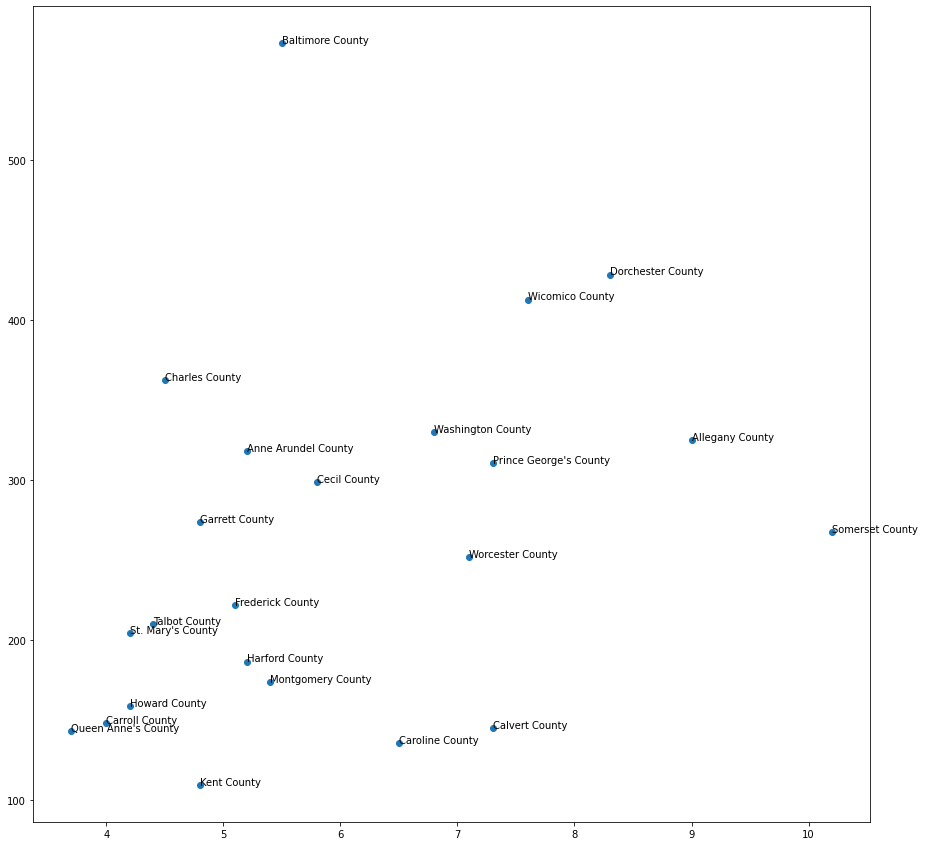

In [ ]:
# linear regression plot for violent crime and unemployment rate
plt.figure(figsize=(15, 15))
x = socio_df['Unemployment Rate']
plt.scatter(x, y)
for i, label in enumerate(socio_df['Jurisdictions']):
  plt.annotate(label, (x[i], y[i]))

# Conclusions 
As we went through this project, TALK ABOUT DATA SCIENCE

Crime is a complex human phenomenon that intuitively is affected by much more than just socioeconomic factors, and addressing crime likewise requires understanding all the different aspects of societies that affect individual behaviors. Studies have shown that there is a causality between inequality and crime in populations<sup>[3] </sup>, but also that individuals’ socioeconomic status and self-reported delinquency is not correlated<sup>[2]</sup>. Our analysis confirms the correlation between higher unemployment rates and higher crime rates in populations, but it is not a direct study, and therefore cannot prove or disprove a causality. If we believe there is a causality as shown in previous studies, then we may also conclude that reducing unemployment rate in Maryland counties should result in reduced crime. The effects of stable employment on crime has been studied extensively and should be referred to for policymakers<sup>[6]</sup>.

# References
[1] https://www.google.com/books/edition/Handbook_of_Crime_Correlates/eD0ttBXoMvQC?hl=en<br>
[2] https://doi.org/10.1111/j.1749-6632.1999.tb08111.x	<br>
[3] https://doi.org/10.1111%2Fj.1745-9125.1999.tb00483.x<br>
[4] https://citeseerx.ist.psu.edu/viewdoc/summary?doi=10.1.1.559.483		<br>
[5] https://doi.org/10.1093%2Fije%2Fdyt066<br>
[6] https://www.ojp.gov/pdffiles1/nij/grants/198118.pdf
